In [122]:
import numpy as np
import pandas as pd
import random
import time

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import xgboost as xgb

# For data visualizatoin
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from bokeh.io import output_notebook, show
from bokeh.models import Title
from bokeh.plotting import figure, output_file, show

import seaborn as sns
%matplotlib inline

from datetime import datetime, timedelta, date

In [140]:
# The dict 'params' consists of all the parameters used in the simulation software for ease of alteration
params = {
#         Set the regression model related parameters
          'train_start_dt':'2013-01',
          'train_stop_dt':'2013-12',
          'y_variable': 'trial_d',
          'X_variables':['trial_n', 'low', 'normal', 'high', 'WIND_DIRECTION', 'WIND_SPEED', 'VISIBILITY', 'MSL_PRESSURE',
                         'AIR_TEMPERATURE', 'DEWPOINT', 'WETB_TEMP', 'STN_PRES', 'WMO_HR_SUN_DUR', 'hour', 'day'],
    
#         Set XGBoost regression parameters (for consumption model)
          'n_estimators': 50,
          'early_stopping_rounds': 50,  #stop if 50 consequent rounds without decrease of error
          'verbose': False,             # Change verbose to True if you want to see it train
          'nthread': 4,
    
#         Set simulator parameters to default values
          'season': 3,
          'day_of_week': 3,
          'special_event': 0,
          'tariff_policy':[],
    
#         Set Occupant behaviour dynamics
          'active_users': .1,     # Set the % of users who are willing to engage in the experiments
          'avail_users': .1,       # Set the % of users who will be available to participate in specific experiment
          'user_latency': 0         # Set the values which correspond to real life participation delay for users 
    
         }

## Structure of the algorithm

The following code is divided in two classes namely, 

- ConsumptionModel
- Simulator

Consumption model primarily consists of the functions related to the basic machine learning model which predicts the dynamic user behaviour

In [141]:
class ConsumptionModel(object):
    def __init__(self, df, params):
        self.df = df
        self.params = params
#         some variables

    def prep_data(self):
        self.df = self.df.dropna().copy()
        one_hot= pd.get_dummies(self.df['tariff'])
        one_hot_renamed = one_hot.rename(index=str, columns={0.0399:'low', 0.1176:'normal', 0.672:'high'}) 
        self.df = self.df.join(one_hot_renamed).drop('tariff', axis=1)
        
        self.df["hour"] = self.df.index.hour
        self.df["day"] = self.df.index.day
        self.df["month"] = self.df.index.month


    
    def train(self):
#         Complete the xgboost model on 2013 data
        self.X_train = self.df.loc[self.params["train_start_dt"]:self.params["train_stop_dt"],self.params["X_variables"]]
        self.y_train = self.df.loc[self.params["train_start_dt"]:self.params["train_stop_dt"],self.params["y_variable"]]
        self.X_test = self.df.loc[self.params["train_stop_dt"]:,self.params["X_variables"]]
        self.y_test = self.df.loc[self.params["train_stop_dt"]:,self.params["y_variable"]]

        self.xg_reg = xgb.XGBRegressor(n_estimators=self.params['n_estimators'], nthread = self.params["nthread"])
        self.xg_reg.fit(self.X_train, self.y_train,
                        eval_set=[(self.X_train, self.y_train), (self.X_test, self.y_test)],
                        early_stopping_rounds = self.params["early_stopping_rounds"],
                        verbose = self.params["verbose"])

#         Get feature importance chart
        return xgb.plot_importance(self.xg_reg, height=0.9) # Plot feature importance
      

    def test(self, X_test):
#         test the data points. Get the predictions
        self.preds = self.xg_reg.predict(X_test)

    def entropy(self):
#         get entropy of each data point nad return the entropy dataframe
        pass


In [150]:
class Simulator:
    
    def __init__(self, df, df_weather, params):
        self.params = params
        self.df = df
        self.df_weather = df_weather
        active_users = int(len(df.columns)*self.params["active_users"])   # get no. of active users from input percentage
        self.active_users = random.sample(list(df.columns), active_users)
        self.noisy_tariff = {}
        self.spring = [3, 4, 5]
        self.summer = [6, 7, 8]
        self.autumn = [9, 10, 11]
        self.winter = [1, 2, 12]


    def select_day(self):
#         Get user ids of participating users
        self.fuzzy_participation()
        
#         Select the season
        if self.params["season"] == -1:
            month = random.randrange(1,12)
        elif self.params["season"] == 0:
            month = random.choice(self.spring)
        elif self.params["season"] == 1:
            month = random.choice(self.summer)
        elif self.params["season"] == 2:
            month = random.choice(self.autumn)
        elif self.params["season"] == 3:
            month = random.choice(self.winter)
            
#         Select the day of week
        if self.params["day_of_week"] == -1:
#             Select random day
            dow = random.randrange(0,7)
        else:
            dow = self.params["day_of_week"] 
            
#         Select the random day from the entries which satisfy above conditions
        shortlist = self.df.loc[(self.df.index.month == month) & (self.df.index.dayofweek == dow), :].index
        day = random.choice(shortlist.day.values)
        year = random.choice(shortlist.year.values)
        timestamp = str(year)+"-"+str(month)+"-"+str(day)
        self.sample = self.df.loc[timestamp,self.avail_users]
        
        
        
    def random_day(self):
#         Get user ids of participating users
        self.fuzzy_participation()
    
#         Sample a random day timestamp
        shortlist = self.df.sample(axis = 0).index
        day = random.choice(shortlist.day.values)
        month = random.choice(shortlist.month.values)
        year = random.choice(shortlist.year.values)
        timestamp = str(year)+"-"+str(month)+"-"+str(day)
        self.sample = self.df.loc[timestamp,self.avail_users]
        
        
    
    def fuzzy_participation(self):
        avail_users = int(len(self.active_users)*self.params["avail_users"])
        self.avail_users = random.sample(self.active_users, avail_users)
    
    
    def auto_noise_addition(self, levels, constraints):
#         select the random users and their behaviour with random latency
        self.noisy_tariff["h1_start"] = [random.choice(range(constraints["h1_start"]-2, constraints["h1_start"]+3)) for _ in range(len(self.avail_users))]
        self.noisy_tariff["h1_end"] = [random.choice(range(constraints["h1_end"]-4, constraints["h1_end"]+2)) for _ in range(len(self.avail_users))]
    

    def tariff_policy(self, levels, constraints):
#         use variables from auto_noise_addition and input variables of this function to create a tariff policy 
#         for each participating user **Needs more attention
        self.auto_noise_addition(levels,constraints)
    
        d = np.ones((48, len(self.avail_users)))
        self.df_tariff = pd.DataFrame(data=d, columns = self.avail_users)
        for i in range(len(self.avail_users)):
            self.df_tariff.loc[self.noisy_tariff["h1_start"][i]:self.noisy_tariff["h1_end"][i], self.avail_users[i]] = 2

        self.df_tariff.index = self.sample.index
        
        
    def run(self):
#         FOR EACH USER, call test function of consumption model, get modified behaviour, return original data point and modified data point
        self.sample = self.sample.interpolate(method = 'linear', axis = 0).ffill().bfill()
        self.sample = self.sample.join(self.df_weather.loc[self.sample.index,:])
        df_response = pd.DataFrame()
        self.sample["hour"] = self.sample.index.hour
        self.sample["day"] = self.sample.index.day
        self.sample["month"] = self.sample.index.month

        for i in range(len(self.avail_users)):
            one_hot= pd.get_dummies(self.df_tariff[self.avail_users[i]])
            one_hot_renamed = one_hot.rename(index=str, columns={1.0:'low', 2.0:'normal', 3.0:'high'}) 
            self.sample = pd.concat([self.sample, one_hot_renamed], axis =1)
            self.sample["high"] = 0

            self.sample["trial_n"] = self.sample[self.avail_users[i]]
            
            consumption_model.test(self.sample[self.params['X_variables']])
            df_response[self.avail_users[i]] = consumption_model.preds
            self.sample = self.sample.drop(['low', 'normal', 'high', 'trial_n'], axis= 1)
            
        df_response['mean']= df_response.mean(axis = 1)
        return df_response['mean']
            
            

In [5]:
df=pd.read_csv('../mod_datasets/aggregate_consumption.csv', sep=',', header=0, index_col=0, parse_dates=['GMT'], low_memory=False)
df = df.drop_duplicates()
df_midas=pd.read_csv('../mod_datasets/midas_weather.csv', sep=',', header=0, index_col=0, parse_dates=['GMT'], low_memory=False)
df_midas_rs = df_midas.resample('30T').mean()
df_interpolated = df_midas_rs.interpolate(method='linear')
df_weather = df_interpolated.loc['2013-01':'2013-12',:]
df_final = pd.concat([df,df_weather], axis=1)

df_n=pd.read_csv('../UKDA-7857-csv/csv/data_collection/data_tables/consumption_n.csv', sep=',', header=0, index_col=0, parse_dates=['GMT'], low_memory=False)
df_n = df_n.drop_duplicates()
df_weath = df_interpolated.copy()

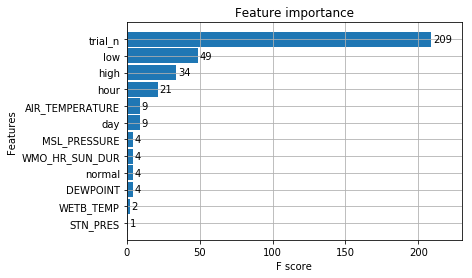

In [148]:
consumption_model = ConsumptionModel(df_final, params)
consumption_model.prep_data()
consumption_model.train()

In [159]:
# Simulating dataframe time index
index = datetime(2013, 4, 10, 10, 30, 0)
h1_start = int(index.hour * 2) + int(index.minute / 30)
h1_end = h1_start + 10

constraints = {"h1_start": h1_start, "h1_end": h1_end}
level = 0       #dummy


sim = Simulator(df_n.loc['2012-05':, :], df_weath.loc['2012-05':, :], params)
sim.select_day()
# sim.sample
sim.tariff_policy(level, constraints)
# sim.noisy_tariff["h1_start"]
response = sim.run()
df_response = pd.DataFrame(data=response, index = sim.sample.index)
# random.sample(range(constraints["h1_start"]-2, constraints["h1_start"]+5), len(sim.avail_users))



In [160]:
# sim.sample = 0

output_notebook()
#     output_file("./temp/line.html") #Uncomment it to save the plot in html file
p=figure(x_axis_type = 'datetime',plot_width=800, plot_height=400)
p.line(sim.sample.index, response.values, line_width=1, color='blue')
p.line(sim.sample.index, sim.sample[sim.avail_users].mean(axis = 1).values, line_width=1, color='red')
show(p)



# response
# sim.sample[sim.avail_users].mean(axis = 1)

Loading BokehJS ...

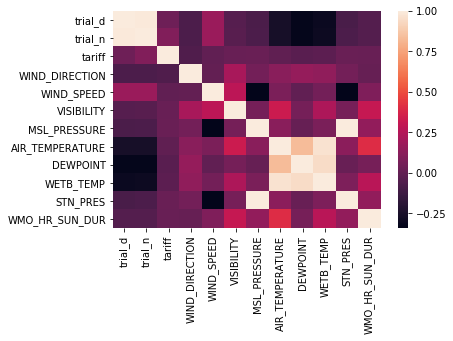

In [132]:
corr = df_final.corr()
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns)